In [24]:
!git clone https://github.com/GwenTsang/Classification_philosophie

Cloning into 'Classification_philosophie'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 73 (delta 23), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 27.11 KiB | 13.56 MiB/s, done.
Resolving deltas: 100% (23/23), done.


Mapping noms complets -> noms affichés utilisés (pour le graphe) :
  Baruch Spinoza  ->  Spinoza
  Christian Wolff  ->  Wolff
  David Hume  ->  Hume
  Francis Hutcheson  ->  Hutcheson
  George Berkeley  ->  Berkeley
  Gottfried Wilhelm Leibniz  ->  Leibniz
  Isaac Newton  ->  Newton
  Jean-Jacques Rousseau  ->  Rousseau
  Johannes Nikolaus Tetens  ->  Tetens
  John Locke  ->  Locke
  Michel de Montaigne  ->  Montaigne
  Nicolas Malebranche  ->  Malebranche
  Platon  ->  Platon
  René Descartes  ->  Descartes
Image enregistrée dans : /content/kant_influences_lastname_grouped.png


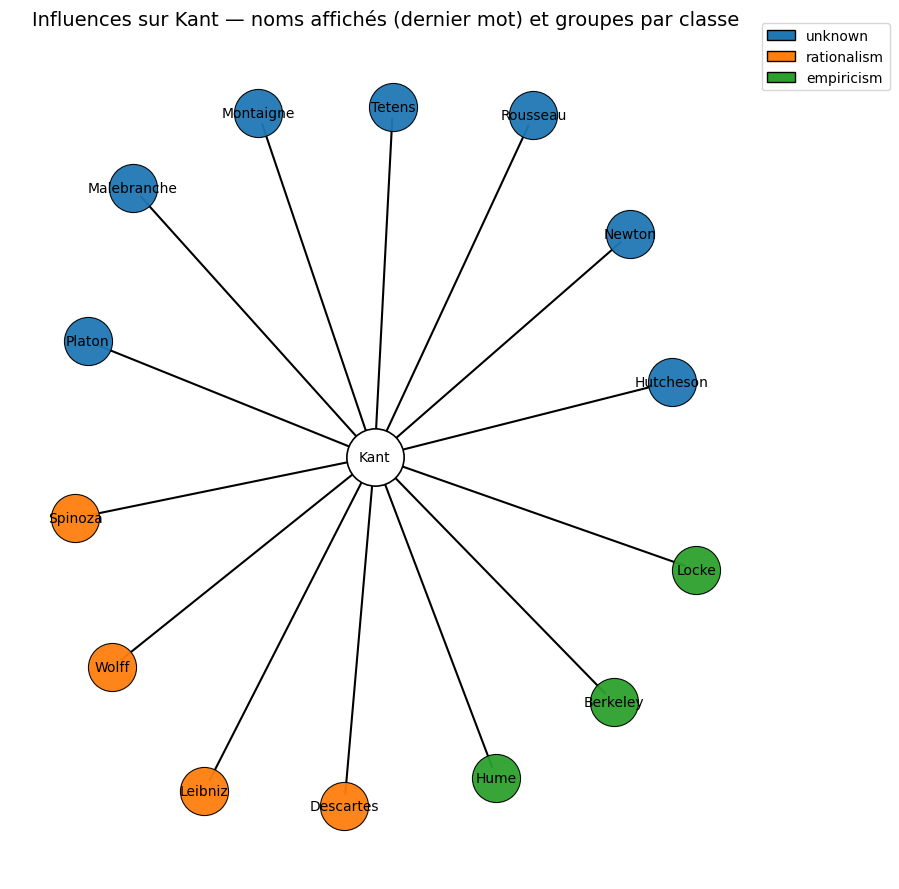

In [25]:
import json
import math
import re
from collections import defaultdict, OrderedDict, Counter

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -------------------------
# utilitaires de nommage
# -------------------------
def clean_token(tok: str) -> str:
    """Nettoie token: retire ponctuation en début/fin et trims."""
    return re.sub(r'^[\W_]+|[\W_]+$', '', tok).strip()

def display_name_from_full(full_name: str) -> str:
    """
    Retourne le dernier mot utile du nom (après nettoyage).
    Exemple: 'Jean-Jacques Rousseau' -> 'Rousseau'
    """
    if not isinstance(full_name, str) or full_name.strip() == "":
        return full_name
    parts = full_name.strip().split()
    # trouver le dernier token non vide et nettoyé
    for tok in reversed(parts):
        ct = clean_token(tok)
        if ct:
            return ct
    return full_name  # fallback

def initials_from_full(full_name: str) -> str:
    """Retourne les initiales des composants sauf le dernier (ex: 'Jean-Jacques Rousseau' -> 'J.'; 'John Paul Smith' -> 'J.P.')"""
    parts = [clean_token(p) for p in full_name.strip().split() if clean_token(p)]
    if len(parts) <= 1:
        return ""
    # tout sauf le dernier
    initials = [p[0].upper() + '.' for p in parts[:-1] if p]
    return ''.join(initials)

# -------------------------
# 1) Charger le JSON
# -------------------------
json_path = "/content/Classification_philosophie/label_to_authors (2).json"
with open(json_path, "r", encoding="utf-8") as f:
    label_to_authors = json.load(f)

# -------------------------
# 2) Trouver la clé 'influenced_Kant'
# -------------------------
influenced_key = None
for k in label_to_authors.keys():
    kl = k.lower()
    if kl == "influenced_kant" or kl == "influenced_kant.":
        influenced_key = k
        break
if influenced_key is None:
    raise KeyError("Aucune entrée 'influenced_Kant' trouvée. Clés disponibles: " + ", ".join(label_to_authors.keys()))

influencers = label_to_authors[influenced_key]
if not isinstance(influencers, list):
    raise ValueError(f"La valeur associée à '{influenced_key}' n'est pas une liste.")

# -------------------------
# 3) Construire mapping auteur -> classe (ignorer influenced_key)
# -------------------------
author_to_label = {}
multi_members = defaultdict(list)
for label, authors in label_to_authors.items():
    if label == influenced_key:
        continue
    for a in authors:
        multi_members[a].append(label)
        if a not in author_to_label:
            author_to_label[a] = label

for a, labs in multi_members.items():
    if len(labs) > 1:
        print(f"Note: l'auteur '{a}' appartient à plusieurs labels: {labs} -> je prends '{author_to_label.get(a)}'.")

# -------------------------
# 4) Regrouper les auteurs influents par label
# -------------------------
labels_present = OrderedDict()
for a in influencers:
    lbl = author_to_label.get(a, "unknown")
    labels_present.setdefault(lbl, []).append(a)

# ordonner labels par taille décroissante pour placement stable/esthétique
labels_sorted = sorted(labels_present.items(), key=lambda kv: -len(kv[1]))
labels_present = OrderedDict(labels_sorted)

# -------------------------
# 5) Construire noms affichés (dernier mot) et gérer collisions
# -------------------------
# première passe : last-token
full_to_display = {}
display_counts = Counter()
for full in influencers:
    disp = display_name_from_full(full)
    full_to_display[full] = disp
    display_counts[disp] += 1

# deuxième passe : désambiguïsation quand besoin
display_used = {}  # mapping final : display -> list of full names
final_display = {}
for full in influencers:
    base = full_to_display[full]
    if display_counts[base] == 1:
        final = base
    else:
        # ajouter initiales
        init = initials_from_full(full)
        if init:
            final = f"{base} ({init})"  # e.g. Smith (J.P.)
        else:
            # si pas d'initiales, fallback à base + un index (sera post-traité si collision)
            final = base
    # gérer collision possible "Smith (J.)" == "Smith (J.)" (deux personnes mêmes initiales) :
    # si final déjà utilisé, ajouter suffixe numérique
    if final in display_used:
        # trouver un suffixe disponible
        idx = 2
        candidate = f"{final}#{idx}"
        while candidate in display_used:
            idx += 1
            candidate = f"{final}#{idx}"
        final = candidate
    display_used.setdefault(final, []).append(full)
    final_display[full] = final

# Impression mapping pour traçabilité
print("Mapping noms complets -> noms affichés utilisés (pour le graphe) :")
for full, disp in final_display.items():
    print(f"  {full}  ->  {disp}")

# -------------------------
# 6) Palette couleurs
# -------------------------
cmap = plt.get_cmap("tab10")
n_labels = len(labels_present)
colors_list = [cmap(i % 10) for i in range(n_labels)]
label_to_color = {lbl: colors_list[i] for i, lbl in enumerate(labels_present.keys())}

# -------------------------
# 7) Construire le graphe dirigé et positions (secteurs angulaires)
# -------------------------
G = nx.DiGraph()
center_node = "Kant"
G.add_node(center_node)

for a in influencers:
    G.add_node(a)        # noeud identifié par nom complet (clé)
    G.add_edge(a, center_node)

positions = {center_node: (0.0, 0.0)}
n_total = len(influencers)
if n_total == 0:
    raise ValueError("La liste 'influenced_Kant' est vide.")

radius = 1.2
sector_gap = 0.08
total_gap = sector_gap * len(labels_present)
available_angle = 2 * math.pi - total_gap
if available_angle <= 0:
    sector_gap = 0.01
    total_gap = sector_gap * len(labels_present)
    available_angle = 2 * math.pi - total_gap

label_angles = {}
for lbl, nodes in labels_present.items():
    k = len(nodes)
    label_angles[lbl] = (k / n_total) * available_angle

angle_cursor = 0.0
for lbl, nodes in labels_present.items():
    sector_angle = label_angles[lbl]
    k = len(nodes)
    start_angle = angle_cursor
    if k == 1:
        angles = [start_angle + sector_angle / 2.0]
    else:
        angles = [start_angle + (i + 0.5) * (sector_angle / k) for i in range(k)]
    for i, a in enumerate(nodes):
        theta = angles[i]
        radial_jitter = 0.06 * ((i % 3) - 1)
        r = radius + radial_jitter
        x = r * math.cos(theta)
        y = r * math.sin(theta)
        positions[a] = (x, y)
    angle_cursor += sector_angle + sector_gap

# -------------------------
# 8) Dessin : utiliser final_display pour les labels
# -------------------------
plt.figure(figsize=(9, 9))
ax = plt.gca()
ax.set_title("Influences sur Kant — noms affichés (dernier mot) et groupes par classe", fontsize=14)

# dessiner noeuds par label (nœuds identifiés par nom complet)
for lbl, nodes in labels_present.items():
    color = label_to_color.get(lbl, (0.7, 0.7, 0.7))
    nx.draw_networkx_nodes(G,
                           positions,
                           nodelist=nodes,
                           node_color=[color],
                           node_size=1200,
                           edgecolors="k",
                           linewidths=0.8,
                           alpha=0.95)

# Kant au centre
nx.draw_networkx_nodes(G,
                       positions,
                       nodelist=[center_node],
                       node_color="white",
                       node_size=1700,
                       edgecolors="black",
                       linewidths=1.2)

# arêtes
nx.draw_networkx_edges(G, positions, edgelist=G.edges(), arrows=True, arrowstyle='->', arrowsize=18, width=1.5)

# labels : map node (full name) -> final display
labels_for_draw = {full: final_display.get(full, display_name_from_full(full)) for full in influencers}
labels_for_draw[center_node] = center_node  # Kant label
nx.draw_networkx_labels(G, positions, labels=labels_for_draw, font_size=10, font_family="sans-serif")

# légende
legend_patches = [Patch(facecolor=label_to_color[lbl], edgecolor='k', label=lbl) for lbl in labels_present.keys()]
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.18, 1.02))

plt.axis('off')
plt.tight_layout()
out_path = "/content/kant_influences_lastname_grouped.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Image enregistrée dans : {out_path}")
plt.show()